# 1. Importing libraries

In [2]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_preprocess import preprocess
from src.support_eda import plot_relation_tv
from src.support_clustering import *


# 2. Data loading

In [3]:
df = pd.read_csv('../data/processed/customers.csv', index_col=0)

df.head()

,Segment,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
CustomerID,,,,,,
AA-315,Consumer,50,15990.66900,165,983.25650,1451.95
AA-375,Consumer,55,6538.68700,169,754.91940,1022.62
AA-480,Consumer,48,19759.08278,175,2071.08818,1815.27
AA-645,Consumer,91,17312.21470,302,2443.09300,1961.27
AB-015,Consumer,88,24644.62750,301,4683.20800,3128.31


# 3. Preprocessing

* Remove the columns we do not want to consider.

    - In this case, we are not going to remove any columns.

* Select the encoding methods for categorical variables.

    - We only have the categorical variable `Segment`, which consists of just three categories. We will perform a Frequency Encoding.

* Select the scaling method.

    - We will initially try using a minmax scaler.

In [4]:
encoding_methods = {"frequency": ['Segment']}

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling)

In [5]:
df_encoded.head()

,Segment,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
CustomerID,,,,,,
AA-315,0.514465,50,15990.66900,165,983.25650,1451.95
AA-375,0.514465,55,6538.68700,169,754.91940,1022.62
AA-480,0.514465,48,19759.08278,175,2071.08818,1815.27
AA-645,0.514465,91,17312.21470,302,2443.09300,1961.27
AB-015,0.514465,88,24644.62750,301,4683.20800,3128.31


In [6]:
df_scaled.head()

,Segment,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
CustomerID,,,,,,
AA-315,1.0,0.272727,0.330596,0.259036,0.481287,0.281043
AA-375,1.0,0.337662,0.072316,0.271084,0.465884,0.165679
AA-480,1.0,0.246753,0.433570,0.289157,0.554668,0.378670
AA-645,1.0,0.805195,0.366708,0.671687,0.579762,0.417901
AB-015,1.0,0.766234,0.567070,0.668675,0.730871,0.731492


# 4. Clustering

We are going to implement different clustering algorithms to see how the customers are segmented.

## 4.1 K-means

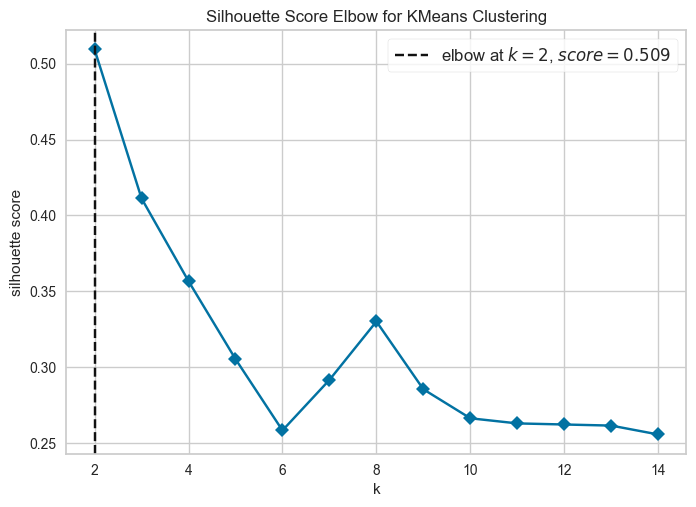

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_scaled)
visualizer.show()

Using the elbow technique and the selected preprocessing, we obtain two clusters, $k = 2$, and a silhouette score of 0.509 (relatively close to 1).  

This means that the data appear to group moderately well into two clusters and that there is no significant overlap between them.

In [8]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_scaled)
labels = km_fit.labels_

### 4.1.1 Metrics

In [9]:
clustering_metrics(df_scaled, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.509319,0.807928,386
1,0.509319,0.807928,409


We observe a Davies-Bouldin index of 0.81, which falls between 0 and 1, indicating moderately adequate cluster compactness and separation.

Additionally, by looking at the cluster cardinality, we can confirm that both have a good size, without significant imbalances.

### 4.1.2 Cluster exploration

In this section, we will compare the obtained clusters to identify their properties.

In [10]:
df_kmeans = df_scaled.copy()

df_kmeans['cluster'] = km_fit.labels_

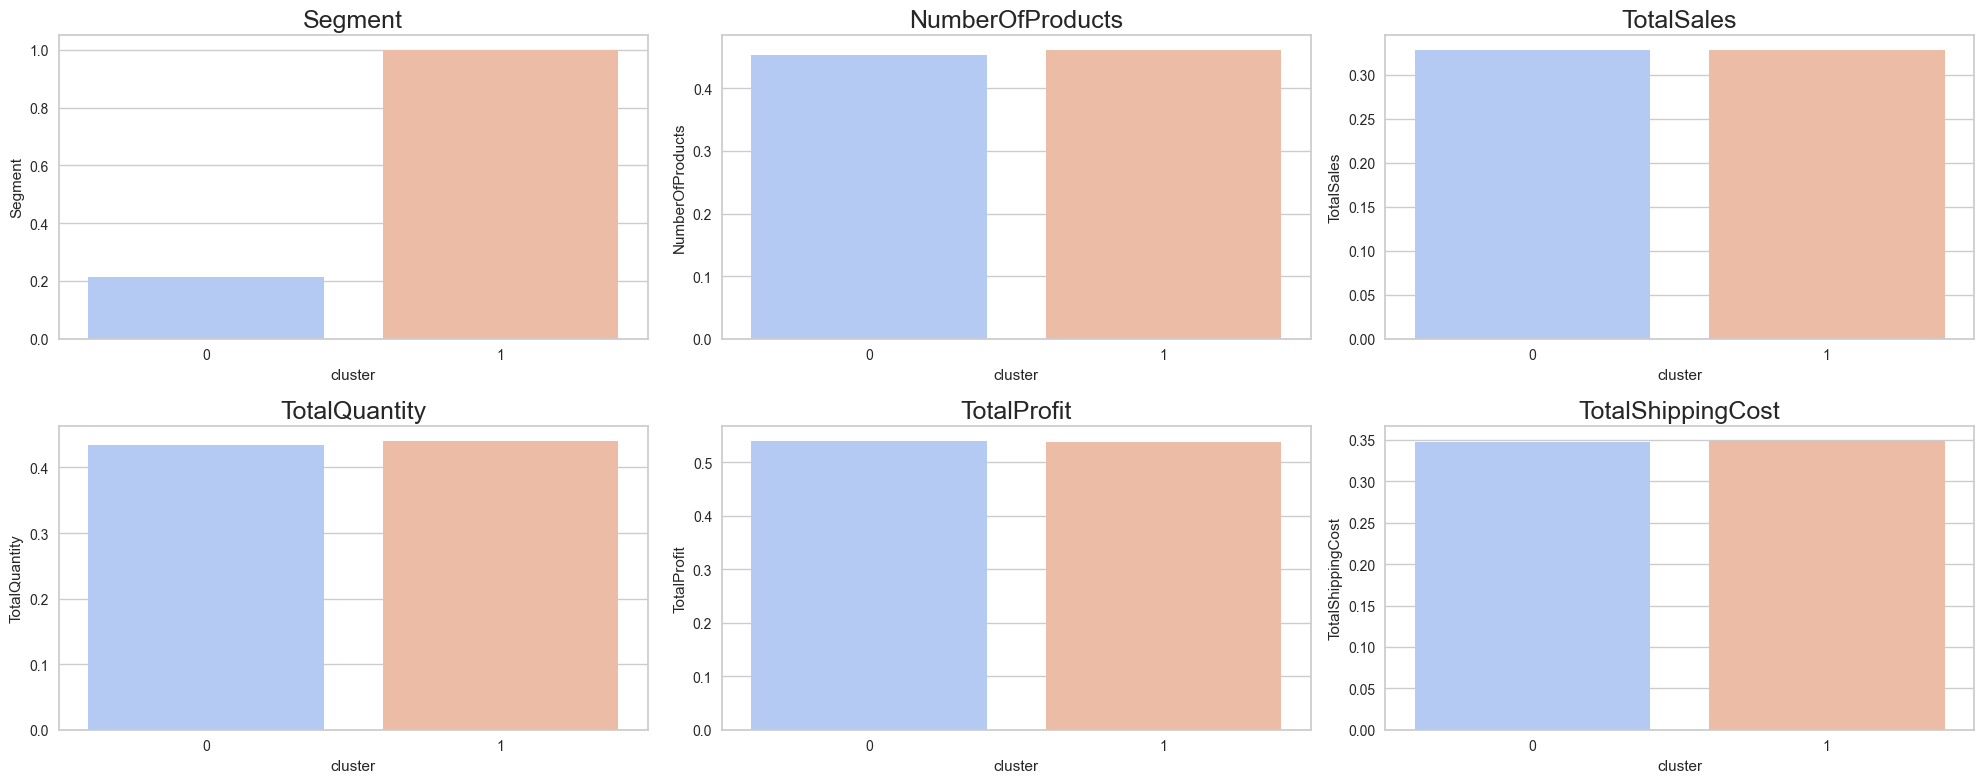

In [11]:
plot_clusters(df_kmeans)

It seems that what characterizes these clusters is the `Segment` to which the customers belong, while the rest of the variables remain balanced. This could indicate a fairly homogeneous population.

#### Radar plot

By creating a radar chart, we can also examine the differences between clusters. Let’s represent the numerical variables.

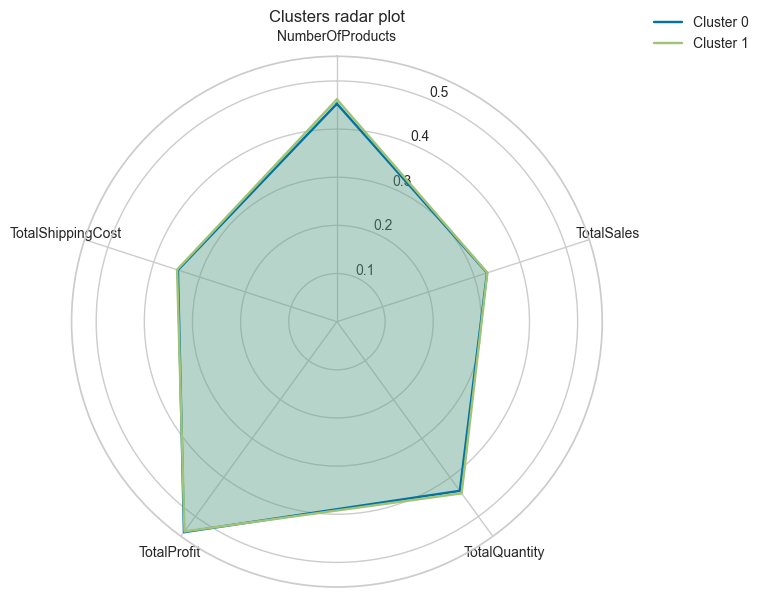

In [12]:
variables = ['NumberOfProducts', 'TotalSales', 'TotalQuantity',
       'TotalProfit', 'TotalShippingCost']

plot_radar(df_kmeans, variables)

#### Histograms

Below, we can see a more detailed distribution of the variables based on the cluster. We can confirm that there is indeed a division by `Segment` and that the rest of the variables are similarly distributed across both clusters.

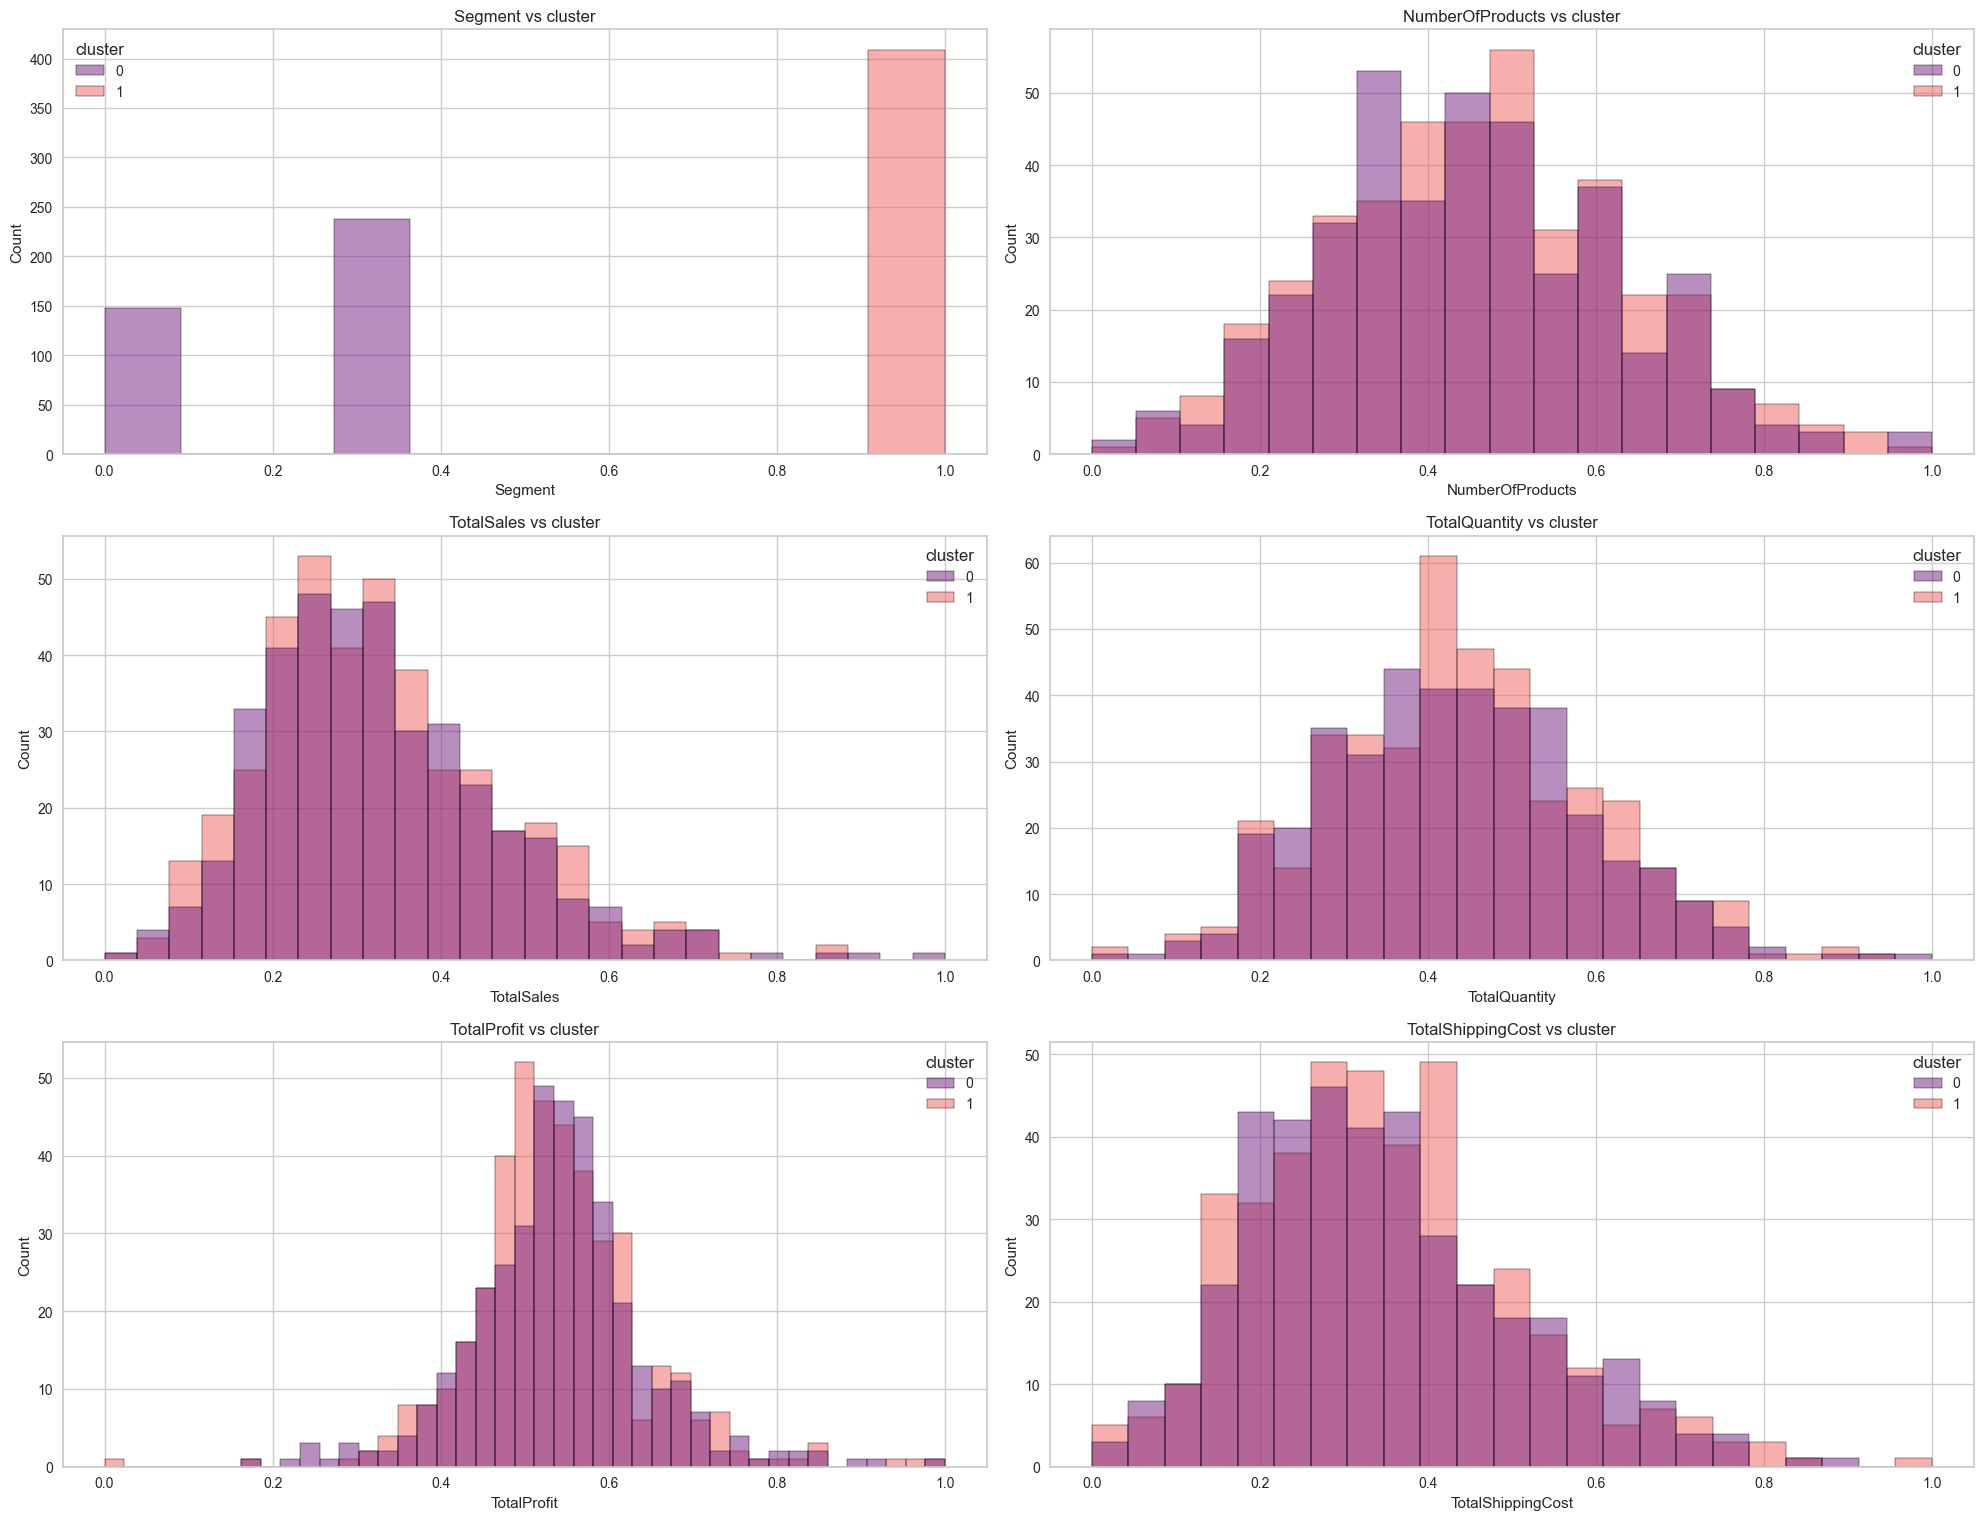

In [13]:
plot_relation_tv(df_kmeans, 'cluster', size=(20, 20), n_cols = 2)

We see that there is really only a division by `Segment`, but it has little influence on the rest of the variables.

## 4.2 Agglomerative clustering

This time, we will use an agglomerative hierarchical clustering model.  

Let’s start by visualizing the dendrograms associated with each type of linkage we can use.

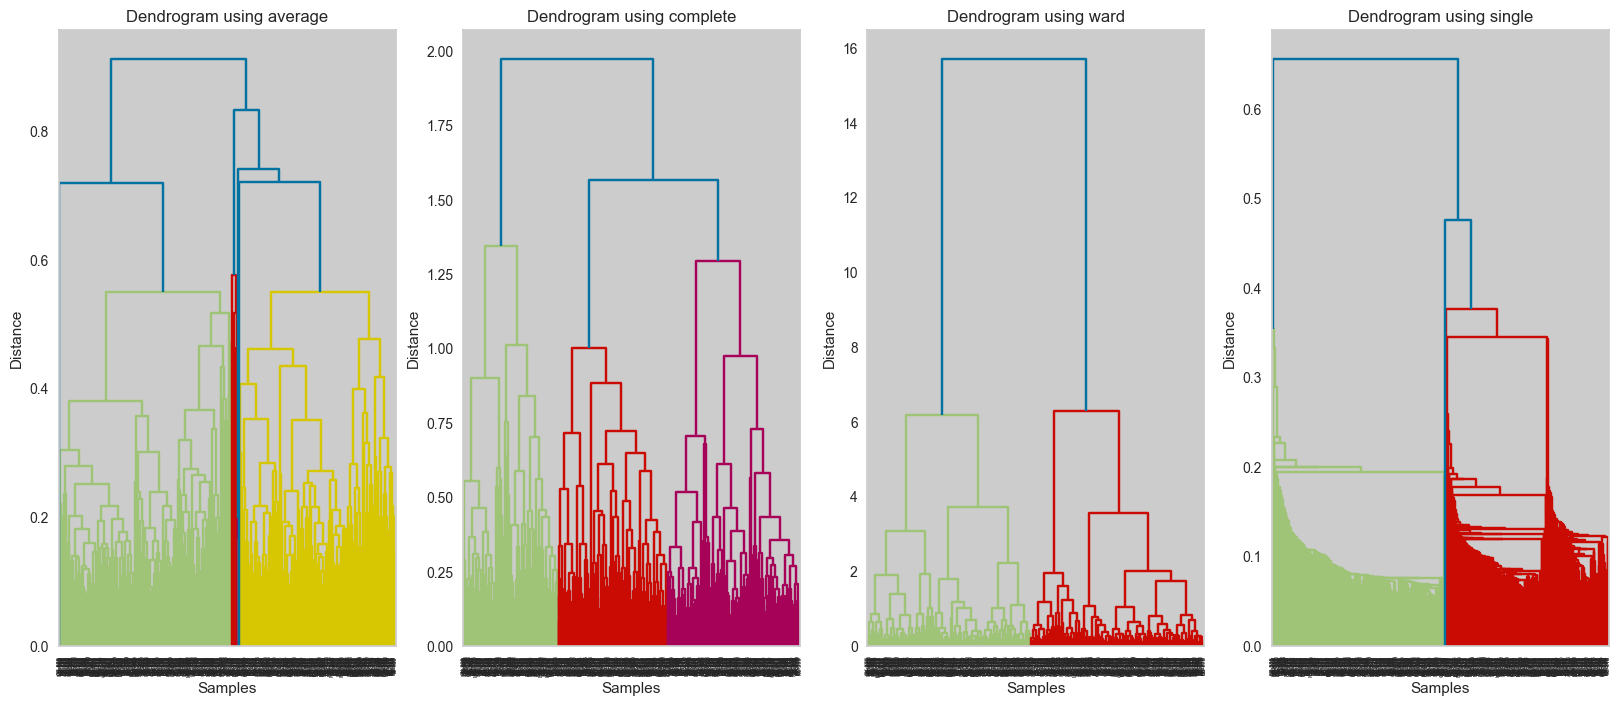

In [14]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

In [15]:
results_df = agglomerative_methods(df_copy)

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [16]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

linkage                             ward
metric                         euclidean
silhouette_score                0.509319
davies_bouldin_index            0.807928
cluster_cardinality     {0: 409, 1: 386}
n_cluster                              2
balance_score                   1.059585
ranking_score                  -1.358194
Name: 12, dtype: object

The best model uses a 'ward' linkage, a Euclidean metric, and once again, 2 clusters.

In [17]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

In [18]:
clustering_metrics(df_scaled, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.509319,0.807928,409
1,0.509319,0.807928,386


The obtained metrics and clusters are the same as those achieved using the K-Means method.

### 4.2.2 Cluster exploration

In [19]:
df_agg = df_scaled.copy()
df_agg["cluster"] = agglo_labels

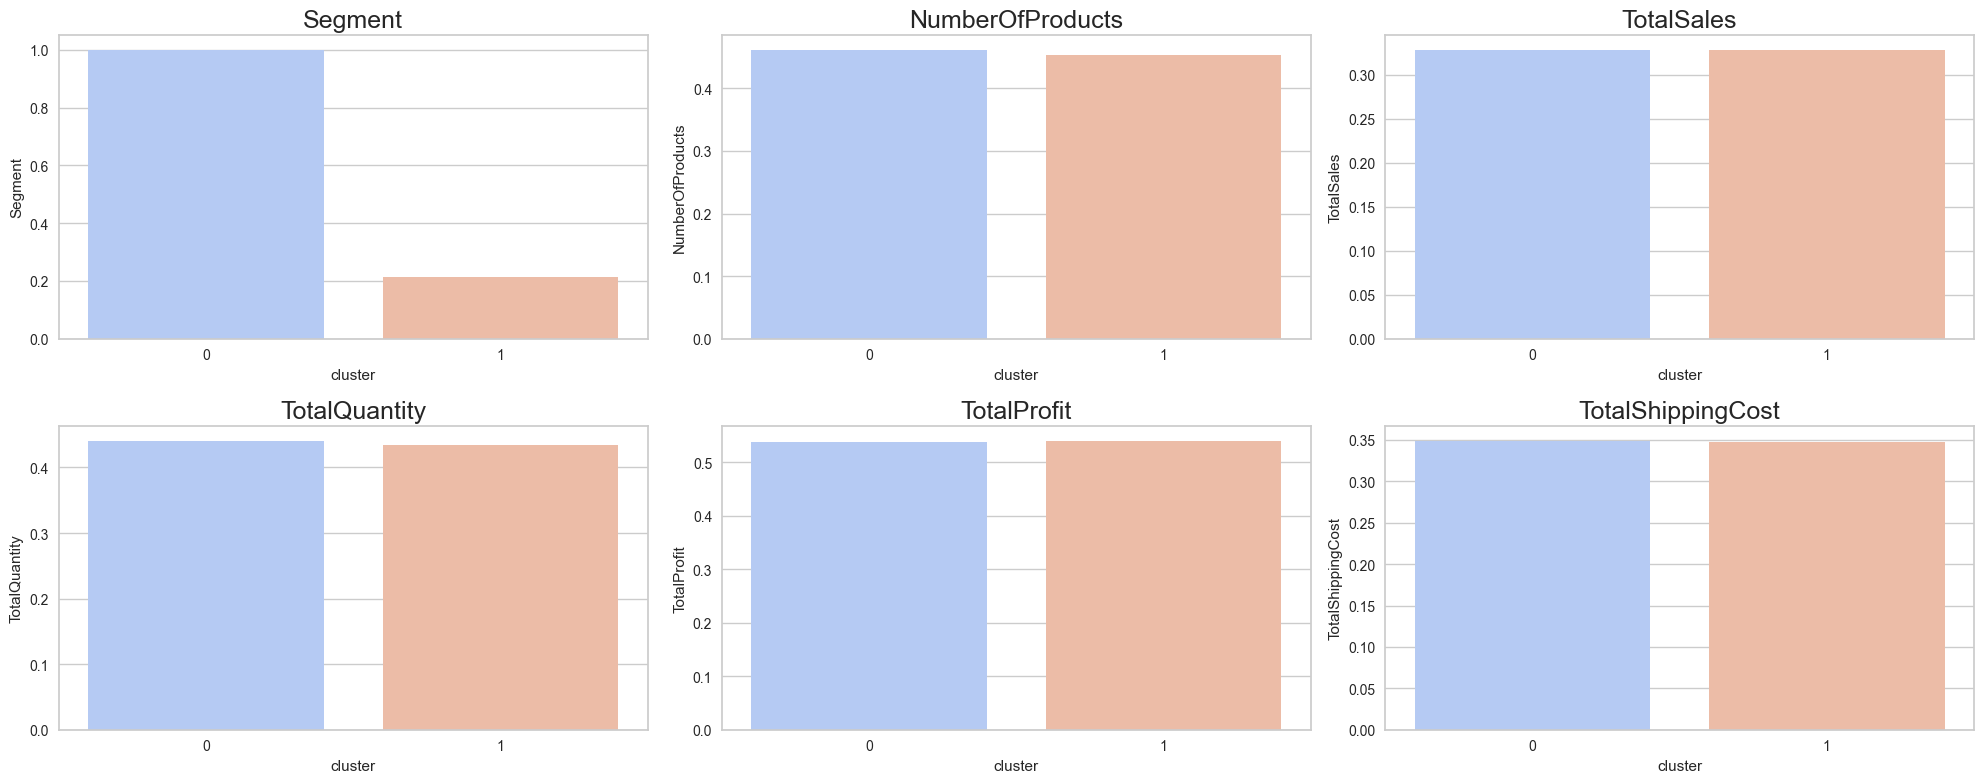

In [20]:
plot_clusters(df_agg)

#### Radar plot

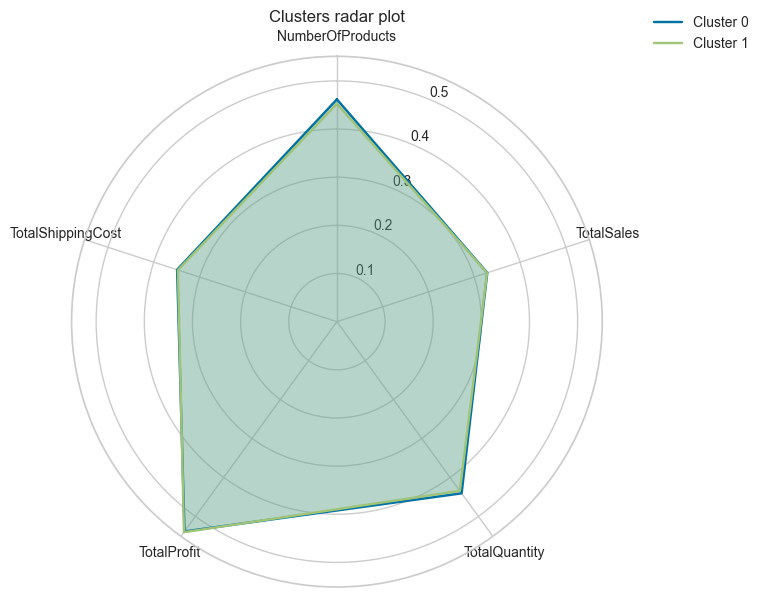

In [22]:
# Select variables to display in radar plot
variables = ['NumberOfProducts', 'TotalSales', 'TotalQuantity',
       'TotalProfit', 'TotalShippingCost']

plot_radar(df_agg, variables)

#### Histograms

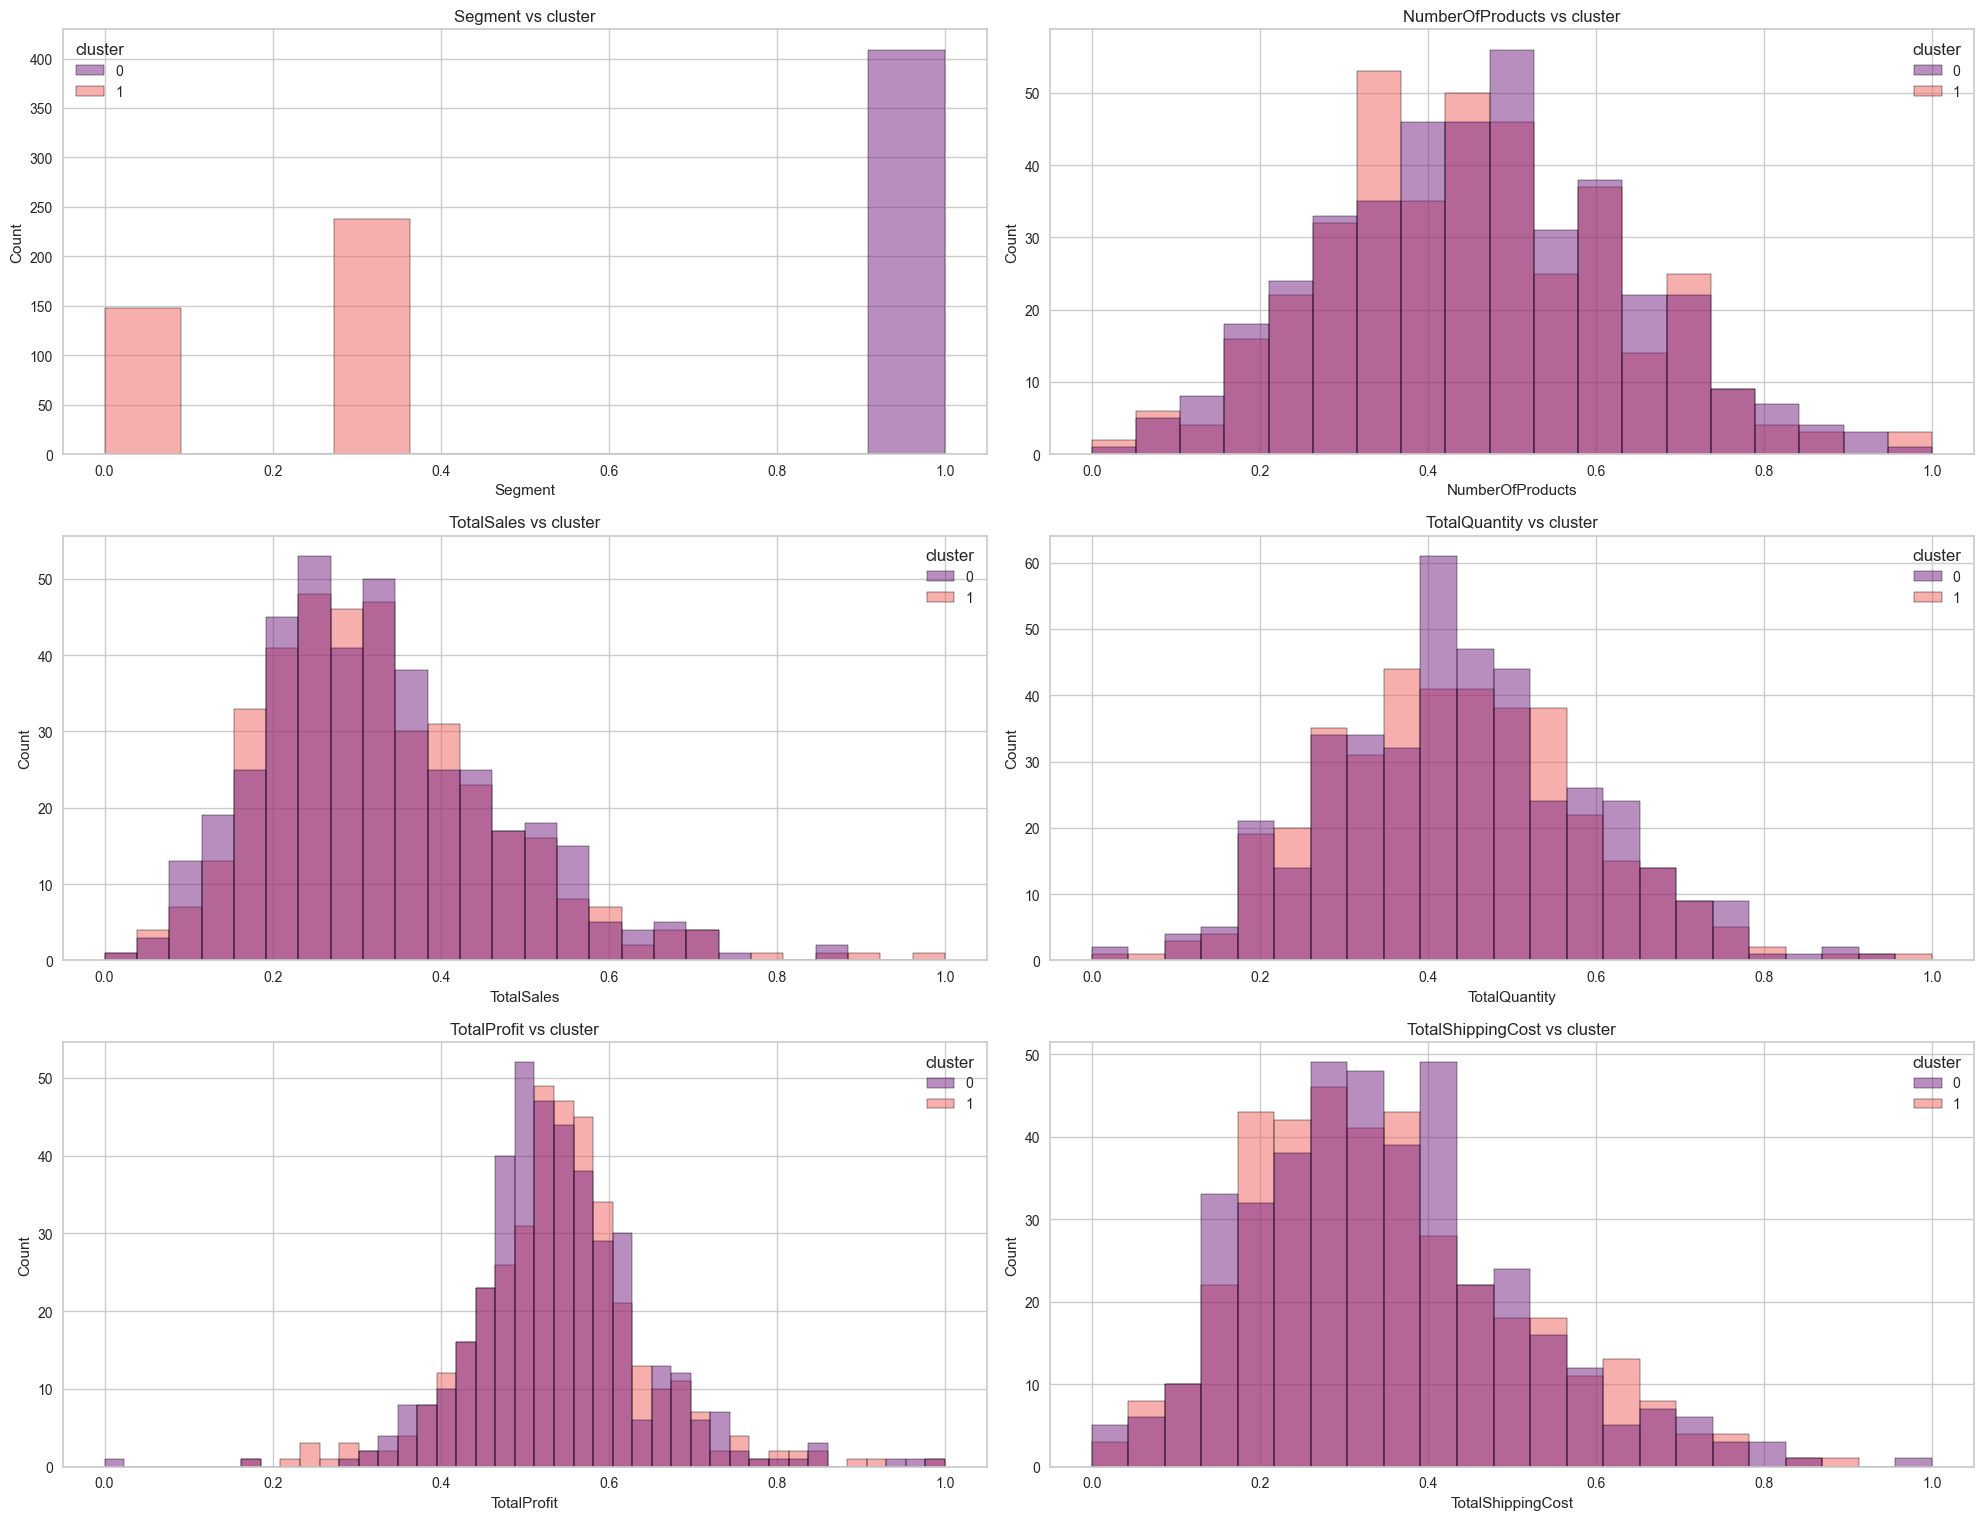

In [23]:
plot_relation_tv(df_agg, 'cluster', size=(20,20), n_cols = 2)

The clustering is exactly the same.

## 4.3 Spectral clustering

In [24]:
spectral_methods(df_scaled)

,n_clusters,assign_labels,silhouette_score,davies_bouldin_score,cardinality
0,2,kmeans,0.509319,0.807928,"{0: 386, 1: 409}"
1,2,discretize,0.509319,0.807928,"{0: 409, 1: 386}"
2,3,kmeans,0.398195,1.092110,"{0: 316, 1: 183, 2: 296}"
3,3,discretize,0.398985,1.040450,"{0: 272, 1: 336, 2: 187}"
4,4,kmeans,0.358117,1.079631,"{0: 155, 1: 240, 2: 231, 3: 169}"
5,4,discretize,0.355389,1.082832,"{0: 231, 1: 162, 2: 178, 3: 224}"
6,5,kmeans,0.265035,1.289651,"{0: 216, 1: 87, 2: 183, 3: 127, 4: 182}"
7,5,discretize,0.263154,1.366627,"{0: 169, 1: 161, 2: 204, 3: 152, 4: 109}"


Spectral clustering brings us back to the previous K-Means model.

## 4.4 DBSCAN Clustering

Next, let’s try the DBSCAN method with different values of epsilon and min_samples.

In [26]:
dbscan_methods(df_scaled, eps_values=[0.1, 0.5, 1], min_samples_values=[5, 10, 15, 20])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
4,0.5,5,0.509319,0.807928,"{0: 409, 1: 386}"
5,0.5,10,0.509319,0.807928,"{0: 409, 1: 386}"
6,0.5,15,0.509319,0.807928,"{0: 409, 1: 386}"
7,0.5,20,0.509319,0.807928,"{0: 409, 1: 386}"
0,0.1,5,0.049670,1.615026,"{-1: 349, 0: 267, 1: 118, 2: 34, 3: 10, 4: 12, 5: 5}"
1,0.1,10,-0.078212,2.435687,"{-1: 476, 0: 63, 1: 229, 2: 18, 3: 9}"
3,0.1,20,-0.148441,1.404425,"{-1: 738, 0: 21, 1: 36}"
2,0.1,15,-0.149754,1.831556,"{-1: 601, 0: 167, 1: 27}"
8,1.0,5,-1.000000,NaN,{'Unique cluster': 795}
9,1.0,10,-1.000000,NaN,{'Unique cluster': 795}


In this case, the optimal parameters appear to be:  

- $epsilon = 0.5$
- $min\_samples = 5$

In [27]:
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)

dbscan_labels = dbscan.fit_predict(df_scaled)

In [28]:
clustering_metrics(df_scaled, dbscan_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.509319,0.807928,409
1,0.509319,0.807928,386


We obtain the same clusters as with the other methods once again.

In [31]:
df_dbscan = df_scaled.copy()
df_dbscan["cluster"] = dbscan_labels

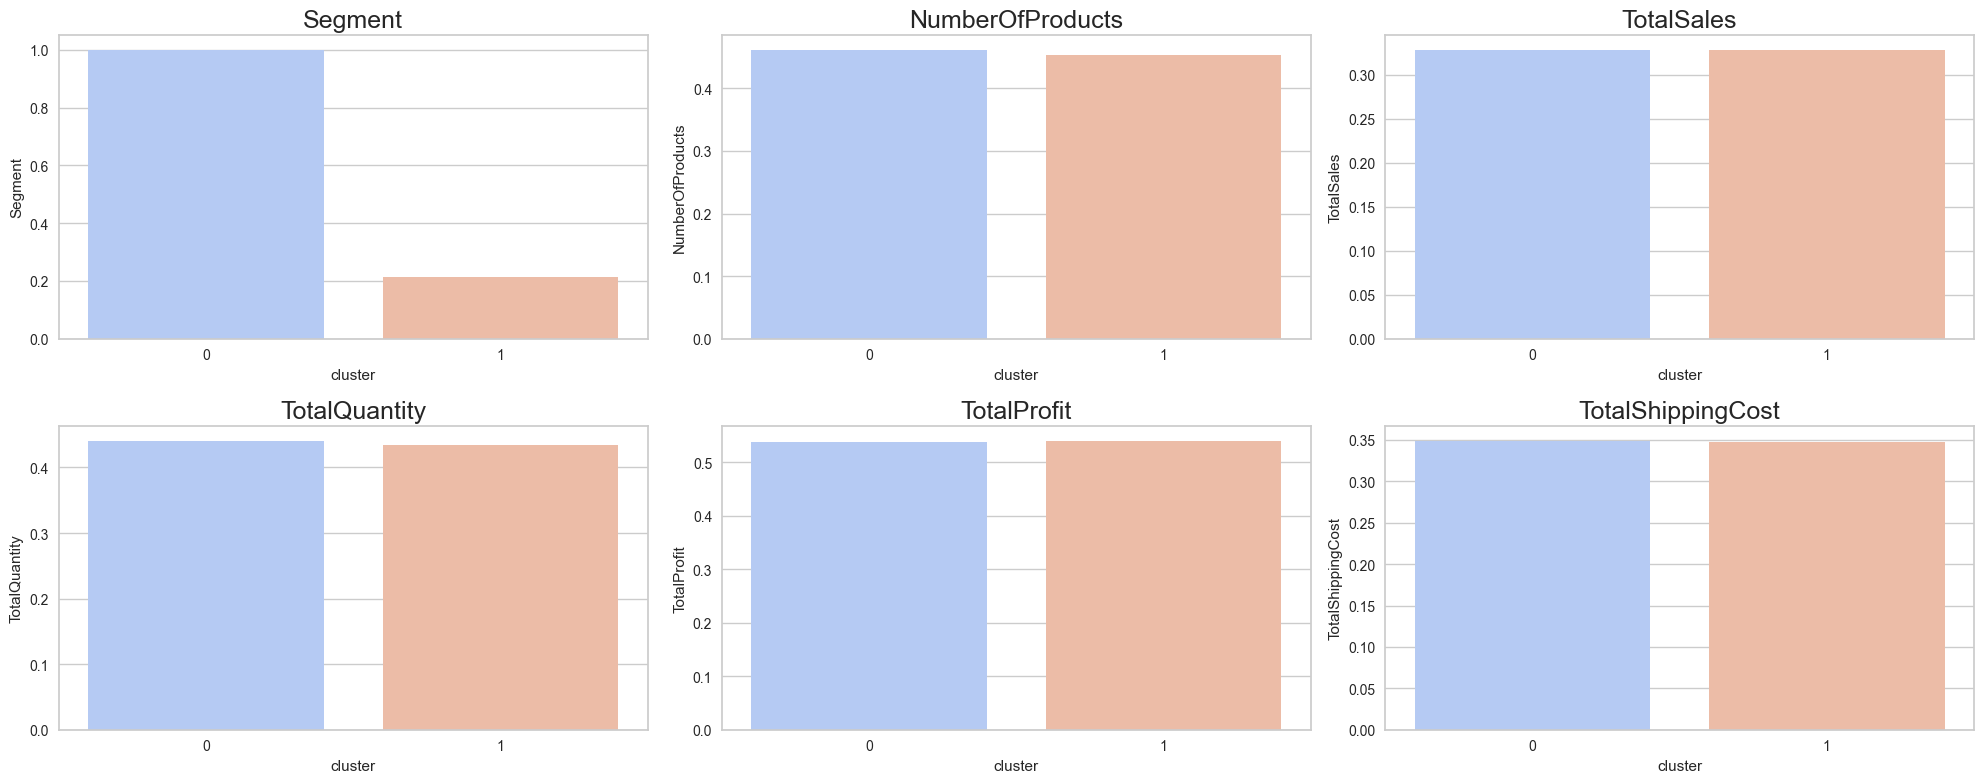

In [32]:
plot_clusters(df_dbscan)

# 5. Conclusions

The cluster structure obtained by all methods is exactly the same, so no method appears to be significantly better than the others.  

Two clusters were obtained, with the only significant difference being the segment to which the customer belongs. Therefore, we cannot draw major conclusions from this.  

## 5.1 Next Steps  

- Perform tests with other preprocessing methods. 
 
- Remove the `Segment` column to try to capture relationships beyond it.  